In [1]:
import numpy as np
import pandas as pd
from sklearn.base import clone 
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RepeatedKFold, KFold, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE, SelectKBest, mutual_info_regression
import matplotlib.pyplot as plt
import time
import json
import sys
import os
# make paths above 'notebooks/' visible for local imports.
# +----------------------------------------------------------------------------+
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.processing import GatherFeatureDatasets
from src.utils import CrossValidation
from src.feature_selection import CustomRFECV
from src.feature_selection import IntrinsicFeatureSelection as ifs
from src.plotting import plot_pairwise_correlations

# Load in the data

In [2]:
proc = GatherFeatureDatasets(is_p=True)

In [3]:
data_dir = '/uufs/chpc.utah.edu/common/home/koper-group3/alysha/magnitudes/feature_splits'
all_train_df = pd.read_csv(f'{data_dir}/p.train.csv')

In [4]:
# Use station YUF for experimenting with models because it has 1433 training examples, 
# which is ~half as much as YNR, so training should go faster. But should still be enough 
# examples for training good models. It is also one of the stations with a 
# UUSS correction, so already used for magnitude calculations and amplitudes should be good quality. 
stat = "YUF"
station_feature_dict, station_meta_dict, feature_names = proc.process_station_datasets(stat, 
                                                                                        all_train_df,
                                                                                        scaler=False,
                                                                                        linear_model=False,
                                                                                        source_dist_type='dist')

YUF
X shape: (1433, 45), y shape: (1433,)


In [5]:
feature_names

array(['amp_ratio_1', 'amp_ratio_2', 'amp_ratio_3', 'amp_ratio_4',
       'amp_ratio_5', 'amp_ratio_6', 'amp_ratio_7', 'amp_ratio_8',
       'amp_ratio_9', 'amp_ratio_10', 'amp_ratio_11', 'amp_ratio_12',
       'amp_ratio_13', 'amp_ratio_14', 'amp_ratio_15', 'amp_ratio_16',
       'amp_ratio_17', 'amp_ratio_18', 'amp_1', 'amp_2', 'amp_3', 'amp_4',
       'amp_5', 'amp_6', 'amp_7', 'amp_8', 'amp_9', 'amp_10', 'amp_11',
       'amp_12', 'amp_13', 'amp_14', 'amp_15', 'amp_16', 'amp_17',
       'amp_18', 'signal_dominant_frequency', 'signal_dominant_amplitude',
       'noise_max_amplitude', 'signal_max_amplitude', 'signal_variance',
       'noise_variance', 'source_depth_km',
       'source_receiver_distance_logkm',
       'source_receiver_back_azimuth_deg'], dtype='<U32')

# RFE to select N

Updates I need to make:

- RFECV is the outer loop
- Select N based on predictor model performance not estimator model performance
- tune predictor model hyperparameter for each N for each fold (optional?)
- Save the optimal N features from each fold 
- For each fold, do RFE with relative and absolute location information
- Save optimal N features (based on average performance for N over all folds) from the entire training set 
- Use MI to limit amplitudes and amplitude ratios (optional?)

In [6]:
### Set Parameters ###
cv_random_state=2652124
# The model to used to estimate feature importance 
estimator_model =  DecisionTreeRegressor()
# Boolean - True if data for estimator_model needs to be scaled
estimator_scaler = False
# The main model to fit
predictor_model = SVR(kernel='rbf')
# Boolean - True if data for model needs to be scaled 
model_scaler = True
# The scoring method to use in RFECV and GridCV
scoring_method = 'r2'
# The function used to evaluate the performance on the test model
score_func = r2_score
# True if a larger score_func value is better
larger_score_is_better = True
# The parameter space for GridCV to search
# Decrease upper-limit of C for linear model because 100 is very slow 
svr_Cspace = [1, 10, 100]
svr_gspace = [0.1, 0.01, 0.001]
param_grid = [
    {'m__C': svr_Cspace, 'm__gamma': svr_gspace},
]
# The number of jobs for RFECV and GridCV to use
n_jobs = 10
# number of folds for outer CV
cv_folds_outer = 10
# number of times to repeat outer CV
n_outer_repeats = 1
# number of folds for inner CV (used for hyperparameter tuning)
cv_folds_inner = 5
# number of folds for the final hyperparameter grid search
cv_folds_hp = 10
# Run grid search over all features
run_gridsearchcv_all = True

### Intrisic feature selection information 
# Function that takes in X, y, list of np arrays containing 
# the indices of features to filter, and K features to select
if_feat_inds = [np.arange(0, 18), np.arange(18, 36)]
if_K = 5
#####################

In [7]:
X = station_feature_dict['X_train']
y = station_meta_dict['y_train']

In [8]:
feat_selection_results = CustomRFECV.do_rfecv(X,
                                            y,
                                            estimator_model,
                                            predictor_model,
                                            param_grid,
                                            estimator_scaler=estimator_scaler,
                                            predictor_scaler=model_scaler,
                                            score_func=score_func,
                                            scoring_method=scoring_method,
                                            n_jobs=n_jobs,
                                            cv_folds_outer=cv_folds_outer,
                                            cv_folds_inner=cv_folds_inner,
                                            n_outer_repeats=n_outer_repeats,
                                            cv_random_state=cv_random_state,
                                            larger_score_is_better=larger_score_is_better,
                                            intrinsic_filter_func=ifs.MI_filter_func,
                                            feature_inds_to_filter=if_feat_inds,
                                            intrinsic_filter_K=if_K
                                            )

reducing features to 19
Fold 0: N=12, test_score=0.845
reducing features to 19
Fold 1: N=9, test_score=0.944
reducing features to 19
Fold 2: N=14, test_score=0.907
reducing features to 19
Fold 3: N=10, test_score=0.941
reducing features to 19
Fold 4: N=14, test_score=0.904
reducing features to 19
Fold 5: N=12, test_score=0.922
reducing features to 19
Fold 6: N=14, test_score=0.921
reducing features to 19
Fold 7: N=15, test_score=0.862
reducing features to 19
Fold 8: N=18, test_score=0.887
reducing features to 19
Fold 9: N=10, test_score=0.904
total time: 424.73 s
Selected number of features: 12 (avg. score of 0.90)


In [24]:
for inds in feat_selection_results['selected_feats']:
    print(inds.shape[0], feature_names[inds])

12 ['amp_ratio_7' 'amp_ratio_11' 'amp_1' 'amp_2' 'amp_3' 'amp_4' 'amp_7'
 'signal_dominant_amplitude' 'signal_variance' 'source_depth_km'
 'source_receiver_distance_logkm' 'source_receiver_back_azimuth_deg']
9 ['amp_ratio_7' 'amp_1' 'amp_2' 'amp_3' 'amp_4' 'signal_variance'
 'source_depth_km' 'source_receiver_distance_logkm'
 'source_receiver_back_azimuth_deg']
14 ['amp_ratio_1' 'amp_ratio_5' 'amp_ratio_7' 'amp_1' 'amp_2' 'amp_3' 'amp_4'
 'amp_8' 'signal_dominant_amplitude' 'signal_max_amplitude'
 'signal_variance' 'source_depth_km' 'source_receiver_distance_logkm'
 'source_receiver_back_azimuth_deg']
10 ['amp_1' 'amp_2' 'amp_3' 'amp_4' 'amp_7' 'signal_dominant_amplitude'
 'signal_max_amplitude' 'source_depth_km' 'source_receiver_distance_logkm'
 'source_receiver_back_azimuth_deg']
14 ['amp_ratio_3' 'amp_ratio_5' 'amp_ratio_7' 'amp_ratio_11' 'amp_1' 'amp_2'
 'amp_3' 'amp_4' 'signal_dominant_amplitude' 'signal_max_amplitude'
 'signal_variance' 'source_depth_km' 'source_receiver_distance

In [12]:
N_feats_to_use = feat_selection_results['best_N']
full_score_array = feat_selection_results['N_scores']
N_avgs = np.average(full_score_array, axis=0)
N_min = np.min(full_score_array, axis=0)
N_max = np.max(full_score_array, axis=0)

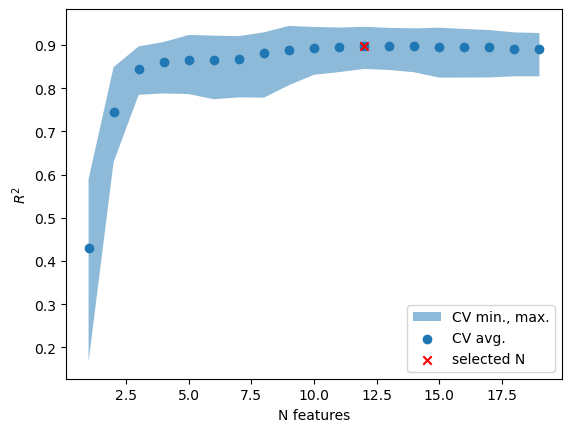

In [26]:
x = np.arange(N_avgs.shape[0])+1
plt.fill_between(x, N_min, N_max, alpha=0.5, label='CV min., max.')
plt.scatter(x, N_avgs, color='C0', label='CV avg.')
plt.scatter(N_feats_to_use, N_avgs[N_feats_to_use-1], marker="x", color='r', label='selected N')
plt.xlabel("N features")
plt.ylabel("$R^2$")
plt.legend(loc='lower right')

# Get N features from entire training set (with same MI filtering and RFE with N features)

In [14]:
# Filter the entire training dataset using MI and the same parameters used in CV
mi_selected_features, mi_filtered_feature_inds = ifs.MI_filter_func(X, 
                                                                    y, 
                                                                    if_feat_inds, 
                                                                    if_K)

In [15]:
print(feature_names[mi_selected_features[0]], feature_names[mi_selected_features[1]])

['amp_ratio_11' 'amp_ratio_7' 'amp_ratio_1' 'amp_ratio_3' 'amp_ratio_5'] ['amp_1' 'amp_2' 'amp_3' 'amp_4' 'amp_7']


In [16]:
X_mi = X[:, mi_filtered_feature_inds]
print(X_mi.shape)

(1433, 19)


In [17]:
estimator_pipeline = CrossValidation.make_simple_pipeline(estimator_model, 
                                                          estimator_scaler)
hp_grid_search, hp_cv = CrossValidation.setup_cv(predictor_model, 
                                                param_grid, 
                                                model_scaler=model_scaler, 
                                                scoring_method=scoring_method, 
                                                n_jobs=n_jobs, 
                                                cv_folds=cv_folds_outer, 
                                                cv_random_state=cv_random_state, 
                                                refit_model=False)

In [18]:
fselector, gs_results, _ = CustomRFECV.custom_rfe(X_mi, 
                                                    y,
                                                    estimator_pipeline,
                                                    N_feats_to_use,
                                                    hp_grid_search)

In [19]:
feature_names[mi_filtered_feature_inds[fselector.support_]]

array(['amp_ratio_3', 'amp_ratio_7', 'amp_1', 'amp_2', 'amp_3', 'amp_4',
       'amp_7', 'signal_dominant_amplitude', 'signal_variance',
       'source_depth_km', 'source_receiver_distance_logkm',
       'source_receiver_back_azimuth_deg'], dtype='<U32')

In [20]:
CrossValidation.get_gridsearchcv_best_results(gs_results)

(0.9020347760773886, 0.03417713423496236, {'m__C': 100, 'm__gamma': 0.01})

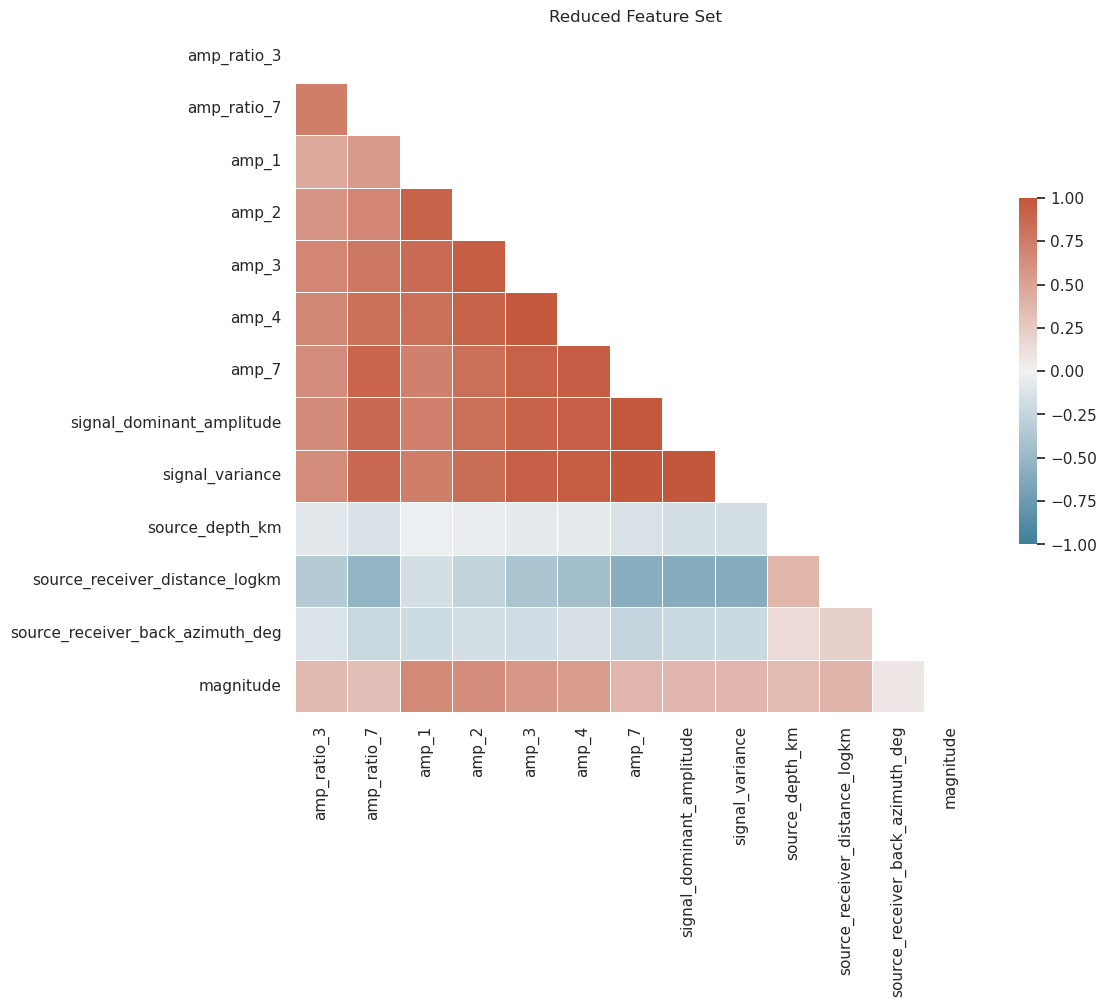

In [28]:
kept_feature_names = feature_names[mi_filtered_feature_inds[fselector.support_]]
plot_pairwise_correlations(X_mi[:, fselector.support_], y, kept_feature_names, "Reduced Feature Set",
                           xticklabels=1)